In [39]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
import sys
import math
from sklearn.preprocessing import StandardScaler
from numpy.linalg import eig
import sys
from random import seed
import pandas as pd
import cvxpy as cp
import random
import numpy.linalg as la
np.random.seed(1)
seed(1)
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [115]:
#creating a random dataset with the equation of a line
def generate_data_straightline(dim_x=1,start=-10,end=10,isNoise=True,isConstant=True,n = 10):
    print("GENERATING DATA")
    X = np.random.uniform(start,end,(n, dim_x))
    W = np.random.randint(1,10,(dim_x, ))
    noise = np.random.uniform(1, 10, n)
    if(isNoise):
      noise = np.random.uniform(1, 20, (n, dim_x))
      X=X+noise
    b=0
    if(isConstant):
      b=np.random.randint(1,500)
    y=np.dot(X,W)
    print("X = ", X.shape, " y = ", y.shape)
    print("Equation of line is ")
    print(W)
    print("constant is "+str(b))
    return X, y

In [116]:
X,Y=generate_data_straightline(dim_x=2,isNoise=True,isConstant=False,n=20)

GENERATING DATA
X =  (20, 2)  y =  (20,)
Equation of line is 
[8 2]
constant is 0


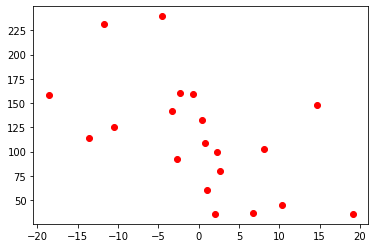

In [117]:
  X_mn_pca=X
  Y_SVM=Y
  pca = PCA(n_components=1)
  X_mn_pca = pca.fit_transform(X_mn_pca)
  plt.scatter(X_mn_pca, Y_SVM, marker='o', facecolors='r', edgecolors='r')

In [118]:
#SVM regression optimisation without kernel
#primal regression problem
def inner_prod_cp(w,x):
    return cp.sum(cp.multiply(w,x))
def SVM_REG_OPT(X,Y, restrictions_on_weight=False,C=10000,eph=0.1):
  M=X.shape[0]
  d=X.shape[1]
  w = cp.Variable(d)
  b=cp.Variable(1)
  qi_pos = cp.Variable(M)
  qi_neg = cp.Variable(M)
  obj=cp.Minimize((1/2)*cp.norm2(w) + cp.sum(qi_pos)*C + C*cp.sum(qi_neg))
  constraints=[]
  for i in range(M):
    constraints+=[inner_prod_cp(w,X[i])+b+qi_pos[i]>=Y[i]-eph,qi_pos[i]>=0]
    constraints+=[inner_prod_cp(w,X[i])+b-qi_neg[i]<=Y[i]+eph,qi_neg[i]>=0]
  problem = cp.Problem(obj,constraints)
  problem.solve()
  return w.value,b.value

In [119]:
def gaussian(x,y,sigma=1):
  exponent = -np.sqrt(la.norm(x-y) ** 2 / (2 * sigma ** 2))
  return np.exp(exponent)
def polynomial(x,y,offset=1):
  d=x.shape[1]
  return (offset + np.dot(x, y)) ** d

In [120]:
#calculating the kernel matrix
def KernelMatrix(X,kernel="gaussian"):
  M=X.shape[0]
  K=np.zeros((M,M))
  for i in range(M):
    for j in range(M):
      if kernel=="gaussian":
        K[i][j]=gaussian(X[i],X[j],sigma=1)
      else:
        K[i][j]=polynomial(X[i],X[j])

  return K       

In [121]:
#kernel regression
#Dual of the same optimisation with kernel
def SVM_REG_DUAL(X,Y,C=10000,eph=0.1):
  M=X.shape[0]
  d=X.shape[1]
  K=KernelMatrix(X)
  qi_pos = cp.Variable(M)
  qi_neg = cp.Variable(M)
  obj=cp.Minimize((1/2)*cp.quad_form(qi_pos-qi_neg,K)+eph*(cp.sum(qi_pos+qi_neg))-cp.sum(cp.multiply(Y,qi_pos-qi_neg)))
  constraints=[]
  for i in range(M):
    constraints+=[qi_pos[i]>=0]
    constraints+=[qi_neg[i]>=0]
    constraints+=[qi_pos[i]<=C,qi_neg[i]<=C]
  constraints+=[cp.sum(qi_pos-qi_neg)==0]
  problem = cp.Problem(obj,constraints)
  problem.solve()
  return qi_pos.value,qi_neg.value

In [122]:
w,b=SVM_REG_OPT(X,Y)

In [123]:
w

array([7.99214953, 1.9980206 ])

In [124]:
b

array([0.13535298])

In [125]:
Ypred_linear=np.dot(X,w)+b

In [126]:
r2_score(Ypred_linear,Y)

0.999998888034201

In [127]:
qi_pos,qi_neg=SVM_REG_DUAL(X,Y)

In [128]:
q=qi_pos-qi_neg

In [129]:
qi_pos

array([ 4.42648123e-18,  1.14830666e+02,  1.46476430e-17,  4.23615747e+01,
        3.13370261e+01,  4.78632679e-18,  3.12099054e-18,  1.07276354e+01,
        1.50671719e-17,  1.48285095e-18, -2.61858552e-19,  1.46669665e-17,
        9.55150452e+00,  1.87731306e-17,  1.23022762e+02,  3.23204482e+01,
        4.39544219e-18,  2.02328007e+01,  3.15420036e+01,  8.29475336e-19])

In [130]:
qi_neg

array([2.84658043e+01, 2.57779802e-17, 7.25686114e+01, 9.32238792e-18,
       6.78037147e-18, 4.22718251e+01, 1.30862288e+01, 3.57310445e-19,
       7.38213980e+01, 2.83083189e+00, 2.78347777e+00, 6.80730479e+01,
       1.86630161e-18, 8.02644812e+01, 2.76564348e-17, 4.23122208e-18,
       2.12248821e+01, 2.82154713e-18, 3.12122986e-18, 1.05358331e+01])

In [131]:
q

array([-28.46580431, 114.83066606, -72.56861139,  42.36157465,
        31.33702606, -42.27182507, -13.08622881,  10.72763545,
       -73.82139804,  -2.83083189,  -2.78347777, -68.07304791,
         9.55150452, -80.26448121, 123.02276236,  32.32044819,
       -21.22488207,  20.23280072,  31.54200357, -10.53583311])

In [132]:
#finding the value of b using a support vector
def findbKernel(X,Y,alpha,kernel="gaussian"):
  M=X.shape[0]
  b=0
  idx=np.argmax(alpha)
  x=X[idx]
  sum=0
  K=np.zeros(M)
  for i in range(M):
    if kernel=="gaussian":
      K[i]=gaussian(x,X[i],sigma=1)
    else:
      K[i]=polynomial(x,X[i])
    sum+=alpha[i]*K[i]
  b=Y[idx]-sum
  return b

In [133]:
b=findbKernel(X,Y,q)

In [134]:
b

116.20980857882694

In [135]:
#predicting the value of unknown samples
def predictWithKernel(Xtest,X,Y,b,alpha,kernel="gaussian"):
  m=Xtest.shape[0]
  n=X.shape[0]
  K=np.zeros((m,n))
  Y_pred=np.zeros(m)
  for i in range(m):
    for j in range(n):
      if kernel=="gaussian":
        K[i][j]=gaussian(Xtest[i],X[j],sigma=1)
      else:
        K[i][j]=polynomial(Xtest[i],X[j])
  for i in range(m):
    sum=0
    for j in range(n):
      sum=sum+(K[i][j]*alpha[j])
    Y_pred[i]=sum+b
  return Y_pred

In [136]:
Y_pred=predictWithKernel(X,X,Y,b,q)

In [137]:
Y_pred

array([ 79.75049133, 231.37796652,  36.15108029, 158.56963219,
       147.53702252,  60.68544016, 102.41278527, 132.39091173,
        36.69224143, 114.36741691, 109.45222354,  44.88084333,
       125.71011952,  35.83736152, 239.58527514, 159.45316397,
        92.12147151, 142.01118361, 160.18274119,  99.37415586])

In [138]:
Y

array([ 79.55049133, 231.37796652,  35.95108029, 158.56963219,
       147.53702252,  60.48544016, 102.21278527, 132.39091173,
        36.49224143, 114.16741691, 109.25222354,  44.68084333,
       125.71011952,  35.63736152, 239.58527514, 159.45316397,
        91.92147151, 142.01118361, 160.18274119,  99.17415586])

In [139]:
r2_score(Y_pred,Y)

0.9999933197143883

In [140]:
from sklearn.svm import SVR
clf = SVR(C=1.0, kernel='linear')
classifier = clf.fit(X,Y)
classifier.score(X,Y)

0.9999988842572421

In [29]:
"""Xtest = np.random.uniform(1,10,(10, 2))
W=np.array([1,5])
Ytest=np.dot(Xtest,W)"""

In [30]:
"""Y_pred_linear=np.dot(Xtest,w)
Y_pred_kernel=predictWithKernel(Xtest,X,Y,b,q)"""

In [ ]:
"""def inner_prod_cp(w,x):
    return cp.sum(cp.multiply(w,x))
def REG_OPT(X,Y,lembda, restrictions_on_weight=False):

  d=X.shape[1:]  
  #print("d",np.array(d)[0])  
  w = cp.Variable(d)
  #obj=cp.Minimize((1/2)*cp.norm2(w) + cp.sum(qi)*C)
  tot_sum = 0  
  for i in range (d[0]):
    tot_sum = tot_sum + cp.abs(Y[i] - inner_prod_cp(w,X[i]))
  
  obj=cp.Minimize(tot_sum + lembda*cp.norm1(w))  
  #  
  constraints=[]
  #for i in range(M):
  #  constraints+=[cp.multiply(Y[i],(inner_prod_cp(w,X[i])))+qi[i]>=1,qi[i]>=0]
  max_X=np.max(X,axis=0)
  min_X=np.min(X,axis=0)
  if restrictions_on_weight:
    for i in range(np.array(d)[0]):
      constraints+=[w[i]<=max_X[i]]
      constraints+=[w[i]>=min_X[i]]
  problem = cp.Problem(obj)
  problem.solve(solver=cp.GLPK)
  #print(w.value)  
  return w.value"""